# Basic Methods for ODEs

## Test case: orbits

We'll use the case of the Earth orbiting the Sun as our test case (we'll assume that the mass of the Earth is insignificant compared to the mass of the Sun).

```{tip}
This is a nice test case for integrating ODEs because we have a lot of intuition for the problem.  If we setup the orbit to be circular, we would expect the integration to keep Earth the same distance from the Sun as it evolves in its orbit.  If we see Earth spiraling inward or outward, then we know that our integration is not very accurate.
```

Kepler's 3rd law (neglecting the orbiting object's mass) is:

$$ 4\pi^2 a^3 = G M_\star P^2$$

If we work in units of solar masses, astronomical units (AU), and years, then Kepler's third law is

$$a^3 = P^2$$

which implies that Newton's gravitational constant is $G = 4\pi^2$

We will put the Sun at the origin of coordinates.  

![circular orbit around the Sun](ellipse_initial_cond_e0.0.png)

Then our system of equations is

$$\dot{\bf r} = {\bf v}$$

$$\dot{\bf v} = -\frac{GM_\star {\bf r}}{r^3}$$

where ${\bf r} = (x, y)$ and ${\bf v} = (u, v)$ 

```{note}
We could have written our
orbit system as:

$$\ddot{\bf r} = - \frac{GM_\star {\bf r}}{r^3}$$

But this is a second-order ODE.  Most ODE integration methods are designed to work with systems of first-order
ODEs, and we can always write a high-order ODE as a system of first-order ODEs by introducing new variables
(in this case, velocity, ${\bf v}$).
```

## Euler's method

The simplest method to advance the solution starts with the first-order difference approximations we found for a derivative:

$$\frac{{\bf r}^{n+1} - {\bf r}^n}{\tau} = {\bf v}^n + \mathcal{O}(\tau)$$

$$\frac{{\bf v}^{n+1} - {\bf v}^n}{\tau} = {\bf a}({\bf r}^n, {\bf v}^n) + \mathcal{O}(\tau)$$

Here, $\tau$ is the timestep we take and we denote the time-level of the state using a subscript,
so $t^n$ is the current time and $t^{n+1} = t^n + \tau$.
Similarly, our notation ${\bf r}^n$ means ${\bf r}(t^{n})$.  This is called [Euler's method](https://en.wikipedia.org/wiki/Euler_method).

Expressing the new state in terms of the old:

$${\bf r}^{n+1} = {\bf r}^n + \tau \,{\bf v}^n + \mathcal{O}(\tau^2)$$

$${\bf v}^{n+1} = {\bf v}^n + \tau \,{\bf a}({\bf r}^n, {\bf v}^n) + \mathcal{O}(\tau^2)$$

```{note}
The local error is $O(\tau^2)$, but to evolve to some time $T$, we will take a large number of steps, $N$, $N = T/\tau$, so globally, after evolving to the final time, we will have an error that is $O(\tau)$.  

Therefore Euler's method is first-order accurate.
```

Graphically, for the ODE $\dot{y} = -y$, Euler's method looks like:

![Euler's method](rk2_Euler.png)

We find the slope at $t^n$ and follow it forward for the full $\tau$ to $t^{n+1}$.

Now let's do our orbits.  We need a function that returns the righthand side of the ODEs, so we'll write that first.  We'll define a special type, called `OrbitState`, that holds the position and velocity, as well as defines operators that allow us to add two `OrbitState`s and multiply by a constant.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class OrbitState:
    # a container to hold the star positions
    def __init__(self, x, y, u, v):
        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __add__(self, other):
        return OrbitState(self.x + other.x, self.y + other.y,
                          self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        return OrbitState(self.x - other.x, self.y - other.y,
                          self.u - other.u, self.v - other.v)

    def __mul__(self, other):
        return OrbitState(other * self.x, other * self.y,
                          other * self.u, other * self.v)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __str__(self):
        return f"{self.x:10.6f} {self.y:10.6f} {self.u:10.6f} {self.v:10.6f}"

We'll write our righthand side function in terms of the `OrbitState`.  It will return a new `OrbitState` representing the derivatives.

In [3]:
GM = 4*np.pi**2

def rhs(state):
    """ RHS of the equations of motion."""

    # current radius
    r = np.sqrt(state.x**2 + state.y**2)

    # position
    xdot = state.u
    ydot = state.v

    # velocity
    udot = -GM * state.x / r**3
    vdot = -GM * state.y / r**3

    return OrbitState(xdot, ydot, udot, vdot)

Many times and ODE solver will just give you the solution at the end of integration, so we'll store a list of `OrbitState` objects that constitute the history.

```{tip}
This type of storage is called an _array of structs_ (AoS), and there is a lot of consideration to be done for whether [array of structs or struct of arrays](https://en.wikipedia.org/wiki/AoS_and_SoA) is better for what you are trying to accomplish.

For us the AoS method allows us to easily access the state at any instance in time.
```

Now we can write a driver that takes the initial conditions and integrates to a time $T$ using a constant timestep $\tau$.

In [4]:
def euler_orbit(state0, tau, T):
    """integrate an orbit given an initial position, pos0, and velocity, vel0,
    using first-order Euler integration"""
    
    times = []
    history = []
    
    # initialize time
    t = 0
    
    # store the initial conditions
    times.append(t)
    history.append(state0)
    
    # main timestep loop
    while t < T:
        
        state_old = history[-1]
        
        # make sure that the last step does not take us past T
        tau = min(tau, T - t)

        # get the RHS
        ydot = rhs(state_old)
        
        # do the Euler update
        state_new = state_old + tau * ydot
        t += tau
        
        # store the state
        times.append(t)
        history.append(state_new)
        
    return times, history

We'll start out on the +y axis and give the Earth a counterclockwise circular velocity.

In [5]:
x0 = 0
y0 = 1
u0 = -np.sqrt(GM/y0)
v0 = 0

state0 = OrbitState(x0, y0, u0, v0)

## First orbit

Now let's integrate for one period (T = 1, since our time units are years).  We'll our timestep to be 1 month&mdash;let's see how we do with that.

In [6]:
T = 1
tau = T/12.0

times, history = euler_orbit(state0, tau, 1)

Let's plot the solution.

Text(0, 0.5, 'y [AU]')

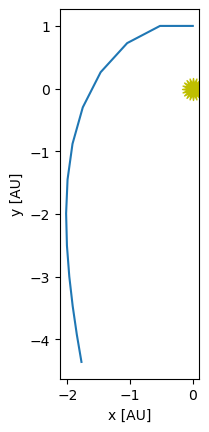

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

xs = [q.x for q in history]
ys = [q.y for q in history]

# draw the Sun
ax.scatter([0], [0], marker=(20,1), color="y", s=250)

# draw the orbit
ax.plot(xs, ys)

ax.set_aspect("equal")
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")

The solution looks awful.  It should be a circle, and after 1 year, we should be right back at where we started.  

## Varying the timestep

Let's look at how we converge with the size of the timestep, $\tau$.

Text(0, 0.5, 'y [AU]')

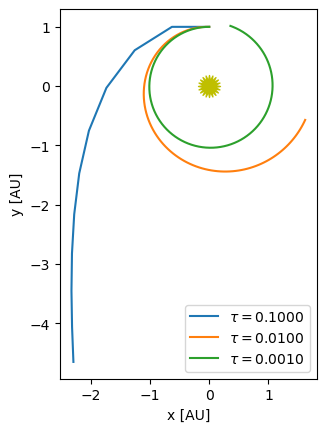

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

# draw the Sun
ax.scatter([0], [0], marker=(20,1), color="y", s=250)

taus = [0.1, 0.01, 0.001]

for tau in taus:
    times, history = euler_orbit(state0, tau, 1)
    xs = [q.x for q in history]
    ys = [q.y for q in history]
    ax.plot(xs, ys, label=rf"$\tau = {tau:6.4f}$")

ax.set_aspect("equal")
ax.legend()
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")

Clearly our solution gets better as we reduce the timestep, but we need to reduce it a lot.  At the top we said that the Euler method is globally first-order accurate.  Let's try to confirm that and then let's look at how we can do higher-order integration.

## Measuring convergence

Imagine evolving for a single period and then asking how well did the integrator do.  We need some metric to determine this.  We can imagine a few different measures:

1. compare the current distance to the Sun to the original distance to the Sun

2. compute the distance from the current $(x, y)$ position to the starting position

3. compute the total energy at the end of the integration and compare to the initial total energy.

There are likely many more.  Unlike the integrals we did previously, where the natural error to compute was the difference between the numerical integral and the analytic one, here there is not a single obvious metric.  So we should pick one or more and look for convergence.  Depending on what our goal is, one metric might be more meaningful than another.

Let's define an error function based on metric 1 above

In [9]:
def error(history):
    
    # define the error to be distance from (0, 0) at end compared to start
    R_orig = np.sqrt(history[0].x**2 + history[0].y**2)
    R_new = np.sqrt(history[-1].x**2 + history[-1].y**2)
    e = np.abs(R_new - R_orig)
    
    return e

Now let's integrate a bunch of orbits, reducing $\tau$ by 2 each time.  Since this is first order accurate, the error should decrease by a factor of 2.

In [10]:
taus = [0.1, 0.05, 0.025, 0.0125, 0.00625]

for tau in taus:
    times, history = euler_orbit(state0, tau, 1)
    print(f"{tau:8} : {error(history)}")

     0.1 : 4.186923100574993
    0.05 : 2.63132561836189
   0.025 : 1.579518716431993
  0.0125 : 0.8788126438377246
 0.00625 : 0.45891625361582156


We see that the decrease in the error is essentially 2.  It is certainly not better than first-order accurate.